In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from pathlib import Path
import re
import requests
from io import StringIO
import random
import pdb
import geopandas as gpd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Secciones

In [ ]:
secciones = gpd.read_file('/content/drive/MyDrive/Code/Data/Seccionado_gipuzkoa/SECC_CE_20210101.shp')
secciones = secciones[secciones['NPRO'] == 'Gipuzkoa']
secciones = secciones[['CUSEC', 'geometry', 'NMUN']]
secciones

,CUSEC,geometry,NMUN
13571,2000101001,"POLYGON ((573368.019 4768463.392, 573369.325 4...",Abaltzisketa
13572,2000201001,"POLYGON ((578062.469 4783728.178, 578060.466 4...",Aduna
13573,2000301001,"POLYGON ((564328.740 4791430.125, 564338.362 4...",Aizarnazabal
13574,2000401001,"POLYGON ((572147.692 4775155.388, 572132.633 4...",Albiztur
13575,2000501001,"POLYGON ((574031.685 4773698.837, 574080.435 4...",Alegia
...,...,...,...
14111,2090301003,"POLYGON ((585338.845 4792840.211, 585354.984 4...",Astigarraga
14112,2090401001,"POLYGON ((571620.111 4768809.437, 571610.801 4...",Baliarrain
14113,2090501001,"POLYGON ((573228.212 4771390.378, 573300.270 4...",Orendain
14114,2090601001,"POLYGON ((569724.081 4769313.986, 569658.075 4...",Altzaga


In [ ]:
renta_x_seccion =  pd.read_excel('/content/drive/MyDrive/Code/Data/renta_x_seccion.xlsx',index_col=0)

# Eliminar pueblos y distritos
renta_x_seccion = renta_x_seccion[renta_x_seccion['Seccion'].str.contains(r'\D*\d{5,}$')]
renta_x_seccion = renta_x_seccion.reset_index(drop=True)

# Quedarme con identificador seccion
renta_x_seccion['Seccion'] = renta_x_seccion['Seccion'].str.extract(r'(\d+)')
renta_x_seccion

,Seccion,Renta neta media por persona
0,2000101001,18052
1,2000201001,16103
2,2000301001,14704
3,2000401001,16229
4,2000501001,14726
...,...,...
540,2090301003,16057
541,2090401001,16428
542,2090501001,16526
543,2090601001,14557


In [ ]:
# Merge geometry and renta_media

df = pd.merge(secciones, renta_x_seccion, left_on='CUSEC', right_on='Seccion', how='left')
df = df.drop(columns='Seccion')
df = df.rename(columns={'CUSEC': 'Seccion', 'Renta neta media por persona ': 'Renta_media'})
df

,Seccion,geometry,NMUN,Renta_media
0,2000101001,"POLYGON ((573368.019 4768463.392, 573369.325 4...",Abaltzisketa,18052
1,2000201001,"POLYGON ((578062.469 4783728.178, 578060.466 4...",Aduna,16103
2,2000301001,"POLYGON ((564328.740 4791430.125, 564338.362 4...",Aizarnazabal,14704
3,2000401001,"POLYGON ((572147.692 4775155.388, 572132.633 4...",Albiztur,16229
4,2000501001,"POLYGON ((574031.685 4773698.837, 574080.435 4...",Alegia,14726
...,...,...,...,...
540,2090301003,"POLYGON ((585338.845 4792840.211, 585354.984 4...",Astigarraga,16057
541,2090401001,"POLYGON ((571620.111 4768809.437, 571610.801 4...",Baliarrain,16428
542,2090501001,"POLYGON ((573228.212 4771390.378, 573300.270 4...",Orendain,16526
543,2090601001,"POLYGON ((569724.081 4769313.986, 569658.075 4...",Altzaga,14557


# Asignar percentil a cada seccion

In [ ]:
# Elimino los pueblos con una sola seccion porque sino me da error al asignar percentiles, obviamente.

# Contar la frecuencia de cada valor en la columna 'Columna'
value_counts = df['NMUN'].value_counts()

# Filtrar el DataFrame para mantener solo las filas con valores que aparecen más de una vez
df = df[df['NMUN'].isin(value_counts[value_counts > 1].index)]
df = df.reset_index(drop=True)

df['Percentil'] = df.groupby('NMUN')['Renta_media'].transform(
    lambda x: pd.qcut(x, q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4])
)
df

,Seccion,geometry,NMUN,Renta_media,Percentil
0,2000901001,"POLYGON ((579824.440 4785932.576, 579844.587 4...",Andoain,14819,1
1,2000901002,"POLYGON ((579575.205 4785316.120, 579573.393 4...",Andoain,15807,4
2,2000901003,"POLYGON ((579495.261 4784945.126, 579468.015 4...",Andoain,14905,2
3,2000901004,"POLYGON ((579561.898 4785537.618, 579532.149 4...",Andoain,15192,2
4,2000901005,"POLYGON ((579693.588 4785883.612, 579693.403 4...",Andoain,14725,1
...,...,...,...,...,...
493,2090201012,"POLYGON ((578987.848 4791557.565, 579210.208 4...",Lasarte-Oria,14370,1
494,2090201013,"POLYGON ((579951.006 4792246.518, 579954.386 4...",Lasarte-Oria,17317,4
495,2090301001,"POLYGON ((587093.652 4794882.225, 587080.653 4...",Astigarraga,16956,4
496,2090301002,"POLYGON ((588243.634 4790624.367, 588242.747 4...",Astigarraga,16663,2


# Buildings

In [ ]:
buildings = gpd.read_file('/content/drive/MyDrive/Code/Results/Buildings/buildings.shp')
buildings

,Town,Referencia,Descripcio,Edificabil,Solar,Vivienda,Trastero,Garaje Cer,Agropecuar,Local Come,...,Terraza,Accesos y,Jardin,Sanidad,Deposito,Duplex,Plaza Park,Religioso,Espectacul,geometry
0,Andoain,7984046,None,0,0,267,92,0,188,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579409.327 4784688.273, 579409.547 4..."
1,Andoain,7984047,None,0,0,160,0,30,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579379.507 4784661.604, 579387.677 4..."
2,Andoain,7984013,None,0,0,108,153,108,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579380.339 4784743.544, 579384.819 4..."
3,Andoain,7984009,None,0,0,348,116,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579330.770 4784723.036, 579326.320 4..."
4,Andoain,7984010,None,0,0,360,108,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579342.980 4784760.725, 579358.430 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45095,Astigarraga,8693041,None,0,0,278,30,29,200,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((586462.762 4793342.393, 586459.195 4..."
45096,Astigarraga,8491186,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((584866.974 4791359.814, 584862.416 4..."
45097,Astigarraga,8893002,None,0,0,177,58,138,0,0,...,24,0,0,0,0,0,0,0,0,"POLYGON ((587961.921 4793110.765, 587965.084 4..."
45098,Astigarraga,8893003,None,0,0,329,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((587961.921 4793110.765, 587967.874 4..."


In [ ]:
# Include section to building
buildings_w_section = gpd.sjoin(buildings, df, how='left', op='within')

# Drop the rows that have not been assigned whichever was the reason. It goes from 45100 to 43503 buildings, hope doesn't affect much.
buildings_w_section = buildings_w_section.dropna(subset=['NMUN'])

buildings_w_section['Percentil'] = buildings_w_section['Percentil'].astype(str)
buildings_w_section

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,Town,Referencia,Descripcio,Edificabil,Solar,Vivienda,Trastero,Garaje Cer,Agropecuar,Local Come,...,Duplex,Plaza Park,Religioso,Espectacul,geometry,index_right,Seccion,NMUN,Renta_media,Percentil
0,Andoain,7984046,None,0,0,267,92,0,188,0,...,0,0,0,0,"POLYGON ((579409.327 4784688.273, 579409.547 4...",8.0,2000901009,Andoain,15975.0,4
1,Andoain,7984047,None,0,0,160,0,30,0,0,...,0,0,0,0,"POLYGON ((579379.507 4784661.604, 579387.677 4...",8.0,2000901009,Andoain,15975.0,4
2,Andoain,7984013,None,0,0,108,153,108,0,0,...,0,0,0,0,"POLYGON ((579380.339 4784743.544, 579384.819 4...",8.0,2000901009,Andoain,15975.0,4
3,Andoain,7984009,None,0,0,348,116,0,0,0,...,0,0,0,0,"POLYGON ((579330.770 4784723.036, 579326.320 4...",8.0,2000901009,Andoain,15975.0,4
4,Andoain,7984010,None,0,0,360,108,0,0,0,...,0,0,0,0,"POLYGON ((579342.980 4784760.725, 579358.430 4...",8.0,2000901009,Andoain,15975.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45094,Astigarraga,8693031,None,0,0,311,13,38,0,0,...,0,0,0,0,"POLYGON ((586453.475 4793333.174, 586455.884 4...",495.0,2090301001,Astigarraga,16956.0,4
45095,Astigarraga,8693041,None,0,0,278,30,29,200,0,...,0,0,0,0,"POLYGON ((586462.762 4793342.393, 586459.195 4...",495.0,2090301001,Astigarraga,16956.0,4
45096,Astigarraga,8491186,None,0,0,0,0,0,0,0,...,0,0,0,0,"POLYGON ((584866.974 4791359.814, 584862.416 4...",496.0,2090301002,Astigarraga,16663.0,2
45097,Astigarraga,8893002,None,0,0,177,58,138,0,0,...,0,0,0,0,"POLYGON ((587961.921 4793110.765, 587965.084 4...",496.0,2090301002,Astigarraga,16663.0,2


In [ ]:
# Change to gdf
buildings_w_section = gpd.GeoDataFrame(buildings_w_section)

# Save the GeoDataFrame to a shapefile
buildings_w_section.to_file('/content/drive/MyDrive/Code/Results/Buildings_with_section/buildings_w_section.shp', index=False)

<ipython-input-94-038077a47ebe>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  buildings_w_section.to_file('/content/drive/MyDrive/Code/Results/Buildings_with_section/buildings_w_section.shp', index=False)


<Axes: >

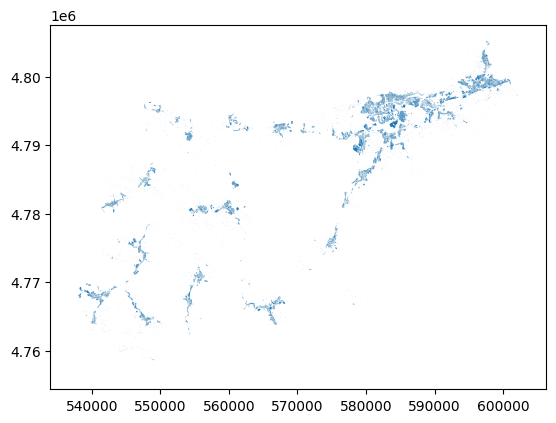

In [ ]:
buildings_w_section.plot()

In [ ]:
import pandas as pd
import random

# Crear DataFrames de personas y edificios
data_personas = {
    'Nombre': ['Juan', 'María', 'Carlos', 'Ana', 'Luis', 'Elena', 'Pedro', 'Sofía', 'María', 'Carlos', 'Ana', 'Luis', 'Elena', 'Pedro', 'Sofía', 'María', 'Carlos', 'Ana', 'Luis', 'Elena', 'Pedro', 'Sofía'],
    'Salario': [1, 3, 2, 1, 4, 3, 2, 4, 3, 2, 1, 4, 3, 2, 4, 3, 2, 1, 4, 3, 2, 4],
}

data_edificios = {
    'Nombre del Edificio': ['1', '2', '3', '4'],
    'Clasificación': [1, 2, 3, 4],
}

df_personas = pd.DataFrame(data_personas)
df_edificios = pd.DataFrame(data_edificios)

# Función para calcular la probabilidad de asignación
def calcular_probabilidad(similitud):
    return 1 / ((similitud + 1) **2)  # Cuanto menor sea la similitud, mayor será la probabilidad

# Asignar a cada persona un edificio basado en la probabilidad
asignaciones = []
for _, persona in df_personas.iterrows():
    salario_persona = persona['Salario']
    probabilidades = []
    for _, edificio in df_edificios.iterrows():
        clasificacion_edificio = edificio['Clasificación']
        similitud = abs(salario_persona - clasificacion_edificio)
        probabilidad = calcular_probabilidad(similitud)
        probabilidades.append(probabilidad)
    edificio_asignado = random.choices(df_edificios['Nombre del Edificio'], weights=probabilidades)[0]
    asignaciones.append(edificio_asignado)

df_personas['Edificio Asignado'] = asignaciones

# Mostrar el resultado de las asignaciones
df_personas

,Nombre,Salario,Edificio Asignado
0,Juan,1,1
1,María,3,3
2,Carlos,2,1
3,Ana,1,2
4,Luis,4,4
5,Elena,3,3
6,Pedro,2,2
7,Sofía,4,3
8,María,3,3
9,Carlos,2,3


In [ ]:
import pandas as pd

# Supongamos que tienes un DataFrame df con una columna 'Pueblo' que contiene los nombres de los pueblos
data = {
    'Nombre del Edificio': ['Edificio A', 'Edificio B', 'Edificio C', 'Edificio D'],
    'Pueblo': ['Pueblo 1', 'Pueblo 2', 'Pueblo 1', 'Pueblo 3'],
    'Altura (metros)': [10, 15, 8, 12],
    'Año de Construcción': [2005, 2010, 2000, 2015]
}

df = pd.DataFrame(data)

# Obtenemos una lista de los pueblos únicos en el DataFrame
pueblos_unicos = df['Pueblo'].unique()

# Creamos un diccionario de DataFrames donde cada clave es el nombre del pueblo y el valor es el DataFrame filtrado
dataframes_por_pueblo = {}

for pueblo in pueblos_unicos:
    nombre_df = 'df_' + pueblo.replace(' ', '').lower()  # Crear un nombre para el DataFrame
    dataframes_por_pueblo[nombre_df] = df[df['Pueblo'] == pueblo]

# Crear variables individuales para cada DataFrame
for nombre_df, dataframe in dataframes_por_pueblo.items():
    globals()[nombre_df] = dataframe

df_pueblo2

,Nombre del Edificio,Pueblo,Altura (metros),Año de Construcción
1,Edificio B,Pueblo 2,15,2010
